## MEMA Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from statannot import add_stat_annotation


print("config loaded")


config loaded


In [2]:
#Setting parameters
results_file = "data/reports_and_datas_MEMA.pk"
info_file = "data/data_info.csv"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

In [3]:
# change --overwrite to True if you want to force to recompute the results
%run ../compute_results.py --mema True --overwrite False 

config loaded.
Performs Bruxism: <False>
Performs MEMA: <True>
Will overwrite existing results: <False>
parameters set
result files exist: Reports creation skipped.


# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [4]:
results = pd.read_pickle(results_file).to_dict()
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=",").query('mema == 1 & included == 1 & session == "1" ')
#data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & subject == "1SL21" & session != "6" ')

print(f"Valid files for mema {data_info.shape[0]}")
print(data_info[["filename", "condition"]])
results_updated = dict()
for filename in results.keys():
    if filename in data_info["filename"].values:
        results_updated[filename] = results[filename]
results = results_updated

Valid files for mema 26
              filename    condition
4   1DA15_nuit_hab.edf  habituation
9   1GB18_nuit_hab.edf  habituation
22  1RA17_nuit_hab.edf  habituation
28    1HB20_nuit_1.edf  habituation
36    1SL21_nuit_2.edf  habituation
40    1UC22_nuit_1.edf  habituation
42    2GA06_nuit_1.edf      control
43    2SJ03_nuit_1.edf      control
49    2LS05_nuit_1.edf      control
50    2CT04_nuit_1.edf      control
57   1ZN04_cohort2.edf       batch2
58   1HS25_cohort2.edf       batch2
59   1PA31_cohort2.edf       batch2
60   3NS01_cohort2.edf       batch2
61   1CB23_cohort2.edf       batch2
62   1RF29_cohort2.edf       batch2
63   1GF14_cohort2.edf       batch2
64   1DM32_cohort2.edf       batch2
65   3BS04_cohort2.edf       batch2
66   3TR07_cohort2.edf       batch2
67   3KB06_cohort2.edf       batch2
68   1NS30_cohort2.edf       batch2
69   1AC26_cohort2.edf       batch2
70   3CL02_cohort2.edf       batch2
71   3TS03_cohort2.edf       batch2
72   3HS08_cohort2.edf       batch2


## Data visualization for the entire cohort for nb MEMA episodes per hour as a function of THR_classif value

In [5]:
def plot_inter_subjects(results, value): 
    for filename in results.keys():
        y_axis=[]
        for report in results[filename]["reports"]:
            y_axis.append(report[value])
        plt.plot(THR_classif[:,1], y_axis, label=filename)
    plt.title('MEMA scoring')
    plt.xlabel('Threshold for classification')
    plt.ylabel(value)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

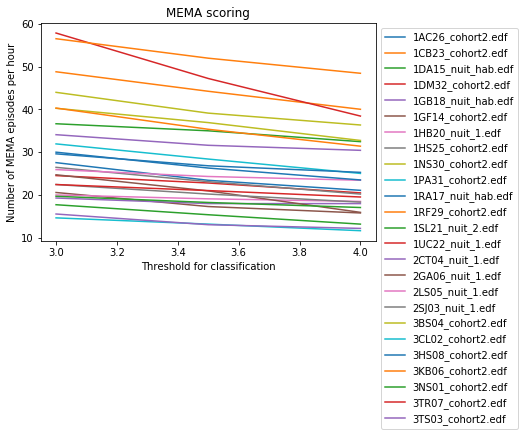

In [6]:
plt.close("all")
plt.figure()
value = "Number of MEMA episodes per hour"
plot_inter_subjects(results, value)

## Data visualization for the entire cohort for nb MEMA bursts as a function of THR_classif value : 

<Figure size 432x288 with 0 Axes>

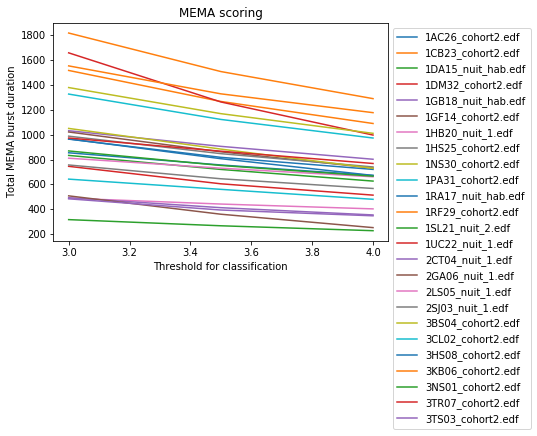

In [7]:
plt.figure()
plt.figure()
value = "Total MEMA burst duration"
plot_inter_subjects(results, value)

## Comparing number of episodes for differents categories and etiologies
1. group by tinnitus volume variation (masking)
2. etiologies

Nb_patients in each group : 
Tinnitus decrease : 10, ['1DA15', '1HB20', '1SL21', '1ZN04', '3NS01', '3BS04', '3TR07', '3KB06', '3CL02', '3HS08']
Tinnitus increase : 9, ['1GB18', '1RA17', '1UC22', '1HS25', '1GF14', '1DM32', '1NS30', '1AC26', '3TS03']
Tinnitus control : 4, ['2GA06', '2SJ03', '2LS05', '2CT04']
Tinnitus stable : 3, ['1PA31', '1CB23', '1RF29']


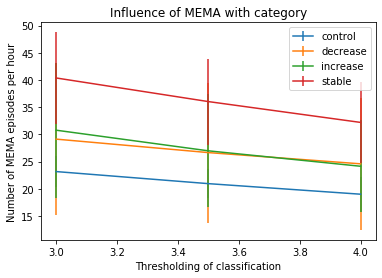

In [8]:
# 1. GROUP BY TINNITUS VOLUME VARIATION
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
data_info["category"] = data_info["mask_delta"].apply(map_category)

reports = reports.merge(data_info, on="filename")

# Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()


# Displaying
plt.figure()
value = "Number of MEMA episodes per hour"
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.errorbar(THR_classif[:,1],report_mean.loc[category][value], report_std.loc[category][value], label = category)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()

Nb_patients in each group : 
Tinnitus ? : 7, ['1DA15', '1GB18', '1RA17', '1HB20', '1SL21', '1UC22', '1ZN04']
Tinnitus group2 : 4, ['2GA06', '2SJ03', '2LS05', '2CT04']
Tinnitus group1 : 8, ['1HS25', '1PA31', '1CB23', '1RF29', '1GF14', '1DM32', '1NS30', '1AC26']
Tinnitus group3 : 7, ['3NS01', '3BS04', '3TR07', '3KB06', '3CL02', '3TS03', '3HS08']
group2_3.0 v.s. group3_3.0: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-7.212e-01
group1_3.0 v.s. group2_3.0: t-test independent samples with Bonferroni correction, P_val=2.711e-01 stat=1.874e+00
group1_3.0 v.s. group3_3.0: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=5.367e-01


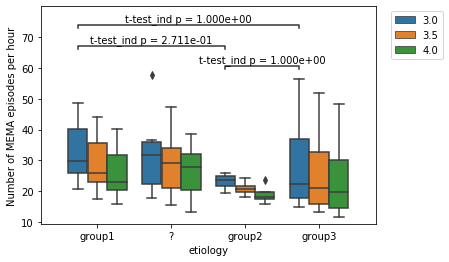

In [16]:
# 2. GROUP BY ETIOLOGIES
print("Nb_patients in each group : ")
for category in list(data_info['etiology'].unique()):
    print(f"Tinnitus {category} : {(data_info['etiology']==category).sum()}, {(list(data_info[data_info['etiology']==category]['subject']))}")


plt.figure()
x = "etiology"
hue = "THR_classif"
ax = sns.boxplot(x=x, y=value, hue=hue, data=reports)

# statistical annotation

thr_val = 3
add_stat_annotation(ax, data=reports, x=x, y=value, hue=hue,
                    box_pairs=[(("group1", thr_val), ("group2", thr_val)),
                                 (("group2", thr_val), ("group3", thr_val)),
                                 (("group1", thr_val), ("group3", thr_val)),
                                ],
                    test='t-test_ind', text_format='full', loc='inside', verbose=2)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))


## Regression between all metrics and all effects variables

In [ ]:
# PREPARE THE VARIABLES TO COMPARE
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys())[0:-1] #(remove power ratio)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]
#reports["Power Ratio"] = reports["Power Ratio"].apply(sum)

In [ ]:
# AUTOMATED LOOP: COMPARE ALL VARIABLES, MAKE REGRESSION AND PLOT
meta_results = pd.DataFrame()
plt.close("all")
data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            regression_result = scipy.stats.linregress(data_loc[x_axis].values,data_loc[y_axis].values)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [ ]:
meta_results.query("pvalue < 0.05 & rvalue > 0.5")